# RSVP Response Prediction for New Tech Meetups

## Developing a Minimum Viable Prouct

In [222]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import itertools
from gensim.models import Word2Vec

#### Read and inspect data

In [2]:
os.getcwd()

'C:\\projects\\event_predictor\\Trainer'

In [3]:
events = pd.read_json('../Data/events.json')
groups = pd.read_json('../Data/groups.json')
users = pd.read_json('../Data/users.json')
venues = pd.read_json('../Data/venues.json')

In [4]:
events[0:3]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,NaN,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572
1,1439890905000,<p>'s Avonds je laptop openklappen om iets leu...,NaN,codecave,Let's code some fun stuff!,12.0,"[{'guests': 0, 'when': 1439922626000, 'respons...",upcoming,1.448476e+12,67856
2,1287573554000,"<p>dear members,</p> <p>Friday 5th of November...",NaN,Digital-Museum-Network-Amsterdam,Presentation of new applications/projects,12.0,"[{'guests': 0, 'when': 1288771966000, 'respons...",past,1.288962e+12,67870


The events dataset contains our target variable of number of RSVPs. It also contains at least 1 feature (*rsvp_limit*) that can be used to predict number of RSVPs, so we can create a minimum viable product just from this dataset.

Our first steps will be:
1. to filter out any events that haven't happened yet as we can't know the final RSVP number for these
2. to parse the count of positive RSVPs from the *rsvps* field
3. to infill null values in *rsvp_limit* - we will choose to infill with the max observed value in case we want to use a model type that will treat it as a continuous feature.

#### Create training data

In [88]:
print("Number of events: %i" % len(events))
print("Number of events in past: %i" % (events.status == 'past').sum())

Number of events: 6200
Number of events in past: 5628


In [345]:
def parse_rsvp(rsvp_json):
    return sum([e['response']=='yes' for e in rsvp_json])

events['rsvp_yes'] = events.rsvps.apply(lambda x: parse_rsvp(x))

selected_data = events[events.status == 'past'][['rsvp_yes','rsvp_limit']]

maxRsvpLimit = selected_data.rsvp_limit.max()
selected_data['rsvp_limit'].fillna(maxRsvpLimit, inplace=True)

selected_data[0:3]

,rsvp_yes,rsvp_limit
0,45,500.0
2,5,12.0
3,79,100.0


Now we define our training and testing sets

In [6]:
X = selected_data.drop('rsvp_yes', axis=1)
Y = selected_data['rsvp_yes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
print("%i records in the training set" % Y_train.count())
print("%i records in the testing set" % Y_test.count())

4221 records in the training set
1407 records in the testing set


#### MVP model

And fit our first model. 

In [71]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

r2_train = r2_score(Y_train, rf.predict(X_train))
r2_test = r2_score(Y_test, rf.predict(X_test))
print("R-square train: %f" % r2_train)
print("R-square test: %f" % r2_test)

R-square train: 0.373529
R-square test: 0.352500


In [72]:
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We observe that this model, although it is very simple so far, already suffers from some overfitting.

Later on we can simplify the model parameters (e.g. switch to a linear model, reduce the tree depth etc.) or even make the most of the few records we have using a k-fold cross-validation scheme. 

However, for now we will persist the trained model so we can use it to develop an MVP (minimum viable product) of the scoring API.

We save the names of the required fields so the API can return a useful error if any fields are missing from the request.

Further discussion of the scoring API is outside of the scope of this presentation.

In [8]:
joblib.dump(rf, '../Data/rf.pkl')

required_fields = ['rsvp_limit']
joblib.dump(required_fields, '../Data/required_fields.pkl')

['../Data/required_fields.pkl']

----

## Create model training and evaluation helpers

Engineering more features won't help us much at this stage, so instead we are going to get more insight into the distribution of the target variable and into the residuals.

Following on from that we will develop a helper function to help us reduce over-fitting.

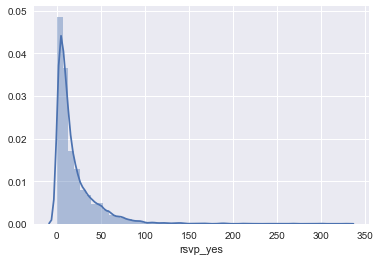

In [9]:
import seaborn as sns
%matplotlib inline
sns.distplot(Y)

Looks like a Poisson distribution. Maybe we could think about a generalised linear model (GLM)?

Let's just check the distribution of *rsvp_limit* as that's likely to be an important feature...

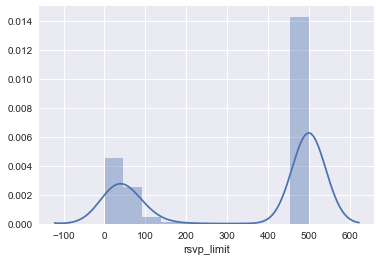

In [10]:
sns.distplot(X.rsvp_limit)

A GLM won't work well with this distribution. Either a non-linear SVM or a random forest are likely to be more productive. Transforming *rsvp_yes* won't help them so let's move on.

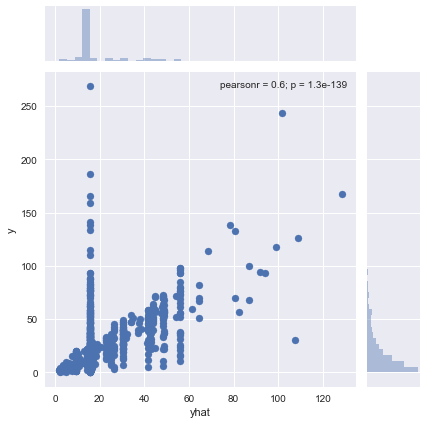

In [11]:
plotDf = pd.DataFrame({'y': Y_test, 'yhat': rf.predict(X_test)})
sns.jointplot(x="yhat", y="y", data=plotDf)

### More sophisticated model building process

Define search space for hyperparameter search.

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, expon

param_dist_rf = {"max_depth": [3, None],
              #"max_features": randint(1, len(X_train.columns)),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators": randint(1, 100),
              "bootstrap": [True, False],
              #"criterion": ["gini", "entropy"]
                }

param_dist_svm = {'C': expon(scale=10),
                  'gamma': expon(scale=1),
                  'kernel': ['rbf', 'linear']}

In [74]:
from sklearn.svm import SVR
rfr = RandomForestRegressor()
svr = SVR()
svr_search = RandomizedSearchCV(svr, param_distributions=param_dist_svm, n_iter=2)
rfr_search = RandomizedSearchCV(rfr, param_distributions=param_dist_rf, n_iter=20)

In [51]:
svr_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=2, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230C0C6EA20>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230C02B6828>, 'kernel': ['rbf', 'linear']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [75]:
rfr_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230C04FC6D8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230C087D438>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000230C0704B38>, 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [139]:
def evaluate(model, X_train, X_test, Y_train, Y_test, plots=True):
    print("Parameters of best model:\n %s" % model.get_params())
    
    if plots:
        plotDf = pd.DataFrame({'y': Y_test, 'yhat': model.predict(X_test)})
        sns.jointplot(x="yhat", y="y", data=plotDf)

    r2_train = r2_score(Y_train, model.predict(X_train))
    r2_test = r2_score(Y_test, model.predict(X_test))
    print("\nR-square train: %f" % r2_train)
    print("R-square test: %f" % r2_test)
    
    if type(model) == RandomForestRegressor:
        print("\n")
        print(pd.DataFrame({'features': X_train.columns, 'importances': model.feature_importances_}). \
        sort_values('importances', ascending=False))
    
    return None

Parameters of best model:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

R-square train: 0.342005
R-square test: 0.369143


     features  importances
0  rsvp_limit          1.0


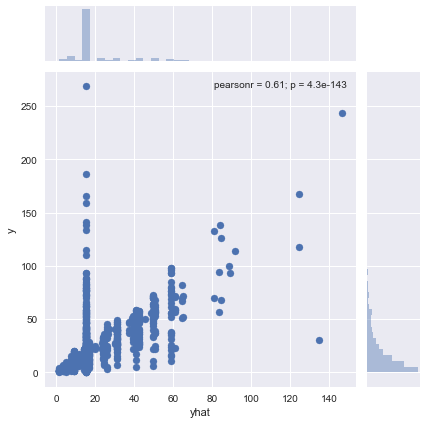

In [130]:
evaluate(rfr_search.best_estimator_)

In [56]:
best_model_idx = svr_search.cv_results_['rank_test_score'].argmin()
print("Mean crossval train score of best model %f" % svr_search.cv_results_['mean_train_score'][best_model_idx])
print("Mean crossval test score of best model %f" % svr_search.cv_results_['mean_test_score'][best_model_idx])

Mean crossval train score of best model 0.237323
Mean crossval test score of best model 0.219570


Parameters of best model:
 {'C': 8.8448116197623108, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.60983073304909063, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

R-square train: 0.244788
R-square test: 0.256405


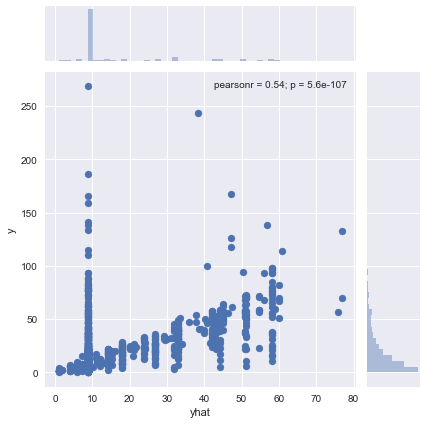

In [57]:
evaluate(svr_search.best_estimator_)


In [140]:
def train_and_evaluate(selected_data, plots=False):
    X = selected_data.drop('rsvp_yes', axis=1)
    Y = selected_data['rsvp_yes']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
    print("%i records in the training set" % Y_train.count())
    print("%i records in the testing set" % Y_test.count())

    rfr_search.fit(X_train, Y_train)
    evaluate(rfr_search.best_estimator_, X_train, X_test, Y_train, Y_test, plots=plots)
    
    return None

----

## Feature engineering

#### Inspect remaining datasets

In [90]:
users[0:2]

,city,country,hometown,memberships,user_id
0,London,gb,None,"[{'joined': 1401194987000, 'group_id': 'online...",45734
1,London,gb,None,"[{'joined': 1400505160000, 'group_id': 'online...",66261


In [60]:
groups[0:2]

,city,created,description,group_id,lat,link,lon,name,topics
0,Den Haag,1386377741000,<p>This group is focused on software architect...,Software-Architecture-and-Project-Design-The-H...,52.080002,http://www.meetup.com/Software-Architecture-an...,4.28,Software Architecture and Project Design The H...,"[WCF, Project Planning, Leadership, Software E..."
1,Amsterdam,1352707128000,<p>FP AMS aims to bring together commercial us...,fp-ams,52.369999,http://www.meetup.com/fp-ams/,4.89,FP AMS,"[Scala Play Framework, Functional Programming,..."


In [62]:
venues[0:2]

,city,country,lat,lon,name,venue_id
0,Groningen,nl,53.214241,6.569170,FabLab / Launchcafé,67082
1,London,gb,51.520836,-0.090599,The Brewery,67083


In [99]:
events[0:2]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id,rsvp_yes
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,NaN,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572,45
1,1439890905000,<p>'s Avonds je laptop openklappen om iets leu...,NaN,codecave,Let's code some fun stuff!,12.0,"[{'guests': 0, 'when': 1439922626000, 'respons...",upcoming,1.448476e+12,67856,3


In [131]:
train_and_evaluate(selected_data)

4221 records in the training set
1407 records in the testing set
Parameters of best model:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 2, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 51, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

R-square train: 0.346180
R-square test: 0.379048


     features  importances
0  rsvp_limit          1.0


In [146]:
users[0:2].memberships[0:2]

0    [{'joined': 1401194987000, 'group_id': 'online...
1    [{'joined': 1400505160000, 'group_id': 'online...
Name: memberships, dtype: object

To parse the users' group membership data we will create numpy arrays to be stacked together to form new columns

In [167]:
memb_joined = users.memberships.apply(lambda membs: [m['joined'] for m in membs]).values
memb_group_id = users.memberships.apply(lambda membs: [m['group_id'] for m in membs]).values
memb_user = users.apply(lambda row: [row.user_id for m in row.memberships], axis=1).values
memberships = pd.DataFrame({'user_id':list(itertools.chain.from_iterable(memb_user)),
                           'joined':list(itertools.chain.from_iterable(memb_joined)),
                           'group_id':list(itertools.chain.from_iterable(memb_group_id))})

In [170]:
memberships[0:2]

,group_id,joined,user_id
0,onlineoptimizers,1401194987000,45734
1,onlineoptimizers,1400505160000,66261


In [325]:
memberships_per_group = memberships.groupby('group_id')['user_id'].count().sort_values(ascending=False)
memberships_per_group[0:10]

group_id
Appsterdam                           3516
Hackers-and-Founders-Amsterdam-NL    3125
ocamsterdam                          2887
PermanentBeta                        2528
sensemakersams                       2146
INTERNATIONALS-in-Rotterdam          2042
mangrove                             1940
SMC050                               1728
OpenCoffeeDenHaag                    1606
StartupWeekendAmsterdam              1525
Name: user_id, dtype: int64

Now we have the group memberships they must be applied per meetup rather than by group to ensure members are only counted as prior members of a group as at the time of the meetup.

In [196]:
events['event_id'] = events.index
events_with_users = events[['event_id','group_id','created']].merge(memberships)
events_with_users[events_with_users.created > events_with_users.joined]
events_with_users[0:3]

,event_id,group_id,created,joined,user_id
0,0,INTERNATIONALS-in-Rotterdam,1309088803000,1314890908000,40788
1,0,INTERNATIONALS-in-Rotterdam,1309088803000,1397202355000,20344
2,0,INTERNATIONALS-in-Rotterdam,1309088803000,1263579736000,42459


In [199]:
group_member_count = events_with_users.groupby('event_id')['group_id'].count()

In [202]:
events['group_member_count'] = group_member_count
events[0:2]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id,rsvp_yes,timeFromCreationToEvent,event_id,group_member_count
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,NaN,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572,45,9.673970e+08,0,2042
1,1439890905000,<p>'s Avonds je laptop openklappen om iets leu...,NaN,codecave,Let's code some fun stuff!,12.0,"[{'guests': 0, 'when': 1439922626000, 'respons...",upcoming,1.448476e+12,67856,3,8.585295e+09,1,97


In [ ]:
events['timeFromCreationToEvent'] = events.time - events.created

In [269]:
events['topics'] = events.merge(groups, on='group_id').sort_values('event_id').reset_index().topics

In [248]:
vecSize = 5
w2vModel = Word2Vec(topics, size=vecSize, min_count=1)

In [229]:
topics[0]

['Expat', 'Social Networking', 'Rotterdam', 'Happy Hour', 'The Netherlands']

In [231]:
w2vModel.wv['Expat']

array([ 2.06295466,  0.32589751, -0.75574696, -0.66395116,  0.61264056], dtype=float32)

In [236]:
[w2vModel.wv[topic] for topic in topics[0:1]][0].mean(axis=1)

array([ 0.31635889, -0.27540594,  0.35037476,  0.27475524,  0.36139756], dtype=float32)

In [256]:
def vectorise_topics(group_topics):
    wvecs = []
    for topic in group_topics:
        try:
            wvecs.append(w2vModel.wv[topic])
        except:
            None
    result = np.vstack(wvecs).mean(axis=0) if len(wvecs)>0 else np.zeros(vecSize)
    return result  

In [270]:
vectorise_topics(['Expat', 'Social Networking', 'Rotterdam', 'Happy Hour', 'The Netherlands', 'Not a real topic'])    

array([ 2.74166942,  0.1116029 , -1.4034183 , -0.99424762,  0.8813138 ], dtype=float32)

In [285]:
def vectorise_topics_vectorised(events):
    vectorised_topics = np.vstack(events.topics.apply(lambda x: vectorise_topics(x)))
    for idx in range(vectorised_topics.shape[1]):
        events['topicvec_' + str(idx)] = vectorised_topics[:,idx]
    return events
        
events = vectorise_topics_vectorised(events)

In [286]:
events[0:2]

,created,description,duration,group_id,name,rsvp_limit,rsvps,status,time,venue_id,rsvp_yes,timeFromCreationToEvent,event_id,group_member_count,topics,topicvec_0,topicvec_1,topicvec_2,topicvec_3,topicvec_4
0,1309088803000,"<p><img src=""http://photos2.meetupstatic.com/p...",NaN,INTERNATIONALS-in-Rotterdam,INTERNATIONALS meet INTERNATIONALS- Midsummer ...,NaN,"[{'guests': 0, 'when': 1309881442000, 'respons...",past,1.310056e+12,68572,45,9.673970e+08,0,2042,"[Expat, Social Networking, Rotterdam, Happy Ho...",2.741669,0.111603,-1.403418,-0.994248,0.881314
1,1439890905000,<p>'s Avonds je laptop openklappen om iets leu...,NaN,codecave,Let's code some fun stuff!,12.0,"[{'guests': 0, 'when': 1439922626000, 'respons...",upcoming,1.448476e+12,67856,3,8.585295e+09,1,97,"[Software Development, New Technology, Program...",0.650777,-1.855275,-2.058244,-1.637294,0.978977


Create columns in event data from group topics

In [296]:
#topic_columns = ['topicvec_' + str(i) for i in range(vecSize)]
required_fields = ['rsvp_limit','duration','timeFromCreationToEvent','group_member_count', 'topics']
selected_events = events[events.status == 'past'][required_fields + ['rsvp_yes']]
selected_events['rsvp_limit'].fillna(selected_data.rsvp_limit.max(), inplace=True)
selected_events['duration'].fillna(-1, inplace=True)
selected_events[0:10]

,rsvp_limit,duration,timeFromCreationToEvent,group_member_count,topics,rsvp_yes
0,500.0,-1.0,9.673970e+08,2042,"[Expat, Social Networking, Rotterdam, Happy Ho...",45
2,12.0,-1.0,1.388446e+09,423,"[Historical Museum, Web Technology, Museum, Ne...",5
3,100.0,10800000.0,1.031852e+10,497,"[Innovation, Product Development, Lean Startup...",79
4,500.0,-1.0,1.827191e+09,344,"[gamification at work, Engagement Design, Ente...",17
5,500.0,16200000.0,5.799950e+08,28,"[E Commerce, E-Commerce, Bio, Online Marketing...",3
6,70.0,10800000.0,1.402211e+09,813,"[Multivariate Testing, Conversion Rate Optimiz...",67
7,500.0,-1.0,5.437650e+08,259,"[Data Visualization, Computer Science, Mobile ...",2
8,500.0,-1.0,2.327766e+09,319,"[Functional Programming, Entrepreneurship, Com...",13
9,20.0,7200000.0,4.513870e+08,3516,"[Android Development, Mobile Development, Open...",9
10,12.0,7200000.0,8.147734e+09,282,"[Agile Project Management, Startup Businesses,...",7


4221 records in the training set
1407 records in the testing set


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Parameters of best model:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 69, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

R-square train: 0.905040
R-square test: 0.733345


                  features  importances
0               rsvp_limit     0.223231
3       group_member_count     0.207181
4               topicvec_0     0.163432
2  timeFromCreationToEvent     0.125979
6               topicvec_2     0.088332
1                 duration     0.083939
8               topicvec_4     0.039779
7               topicvec_3     0.037135
5               topicvec_1     0.030994


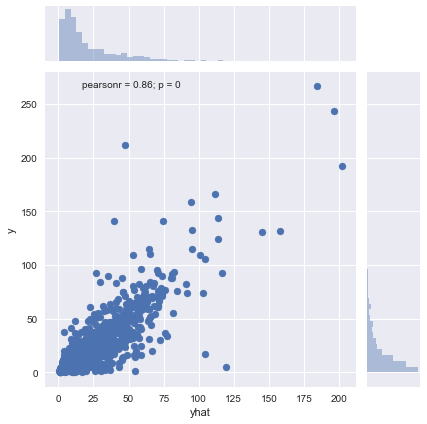

In [293]:
X = selected_events.drop('rsvp_yes', axis=1)
Y = selected_events['rsvp_yes']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
print("%i records in the training set" % Y_train.count())
print("%i records in the testing set" % Y_test.count())

w2vModel = Word2Vec(X_train.topics, size=vecSize, min_count=1)
X_train = vectorise_topics_vectorised(X_train).drop('topics', axis=1)
X_test = vectorise_topics_vectorised(X_test).drop('topics', axis=1)

rfr_search.fit(X_train, Y_train)
evaluate(rfr_search.best_estimator_, X_train, X_test, Y_train, Y_test, plots=True)

There are still many potential features to explore, but won't due to time contraints. Some examples are:
* More vectorised text fields - group description, event description
* Features based on city name - e.g. number of groups and members in each city
* Geographic features - e.g. distance from group to venue, distance of venue to centroid of other venues in the city
* Features based on member hometown - the group count feature that we created could be modified to take into account how many of the members of the group live in the same city as the venue
* Features derived from group home-page e.g. vectorised text of home page; search rank of page for a query based on group topics
* Features based on group competition - is there another event at a similar time in a similar location with a similar topic vector?

## Creating scorer

In [332]:
featureNames = list(X_train.columns.values)
featureNames

['rsvp_limit',
 'duration',
 'timeFromCreationToEvent',
 'group_member_count',
 'topicvec_0',
 'topicvec_1',
 'topicvec_2',
 'topicvec_3',
 'topicvec_4']

In [337]:
import json
with open('../Data/events.json') as f:
    events_example = json.load(f)[0]
    
with open('../Data/groups.json') as f:
    groups_example = json.load(f)[0]
    
required_fields = ['rsvp_limit','duration','time','created','group_id','topics']
example_query = {k:v for k,v in {**groups_example, **events_example}.items() if k in required_fields}

example_query

{'created': 1309088803000,
 'duration': None,
 'group_id': 'INTERNATIONALS-in-Rotterdam',
 'rsvp_limit': None,
 'time': 1310056200000,
 'topics': ['WCF',
  'Project Planning',
  'Leadership',
  'Software Engineering',
  'Enterprise Architecture',
  'Software Development',
  '.NET',
  'IDesign Method',
  'Windows Azure Platform',
  'Software Architecture']}

In [361]:
def score(query):
    record_to_score = np.hstack([np.array([example_query['rsvp_limit'] if example_query['rsvp_limit'] else maxRsvpLimit,
                                       example_query['duration'] if example_query['duration'] else -1,
                                       example_query['time'] - example_query['created'],
                                       memberships_per_group[example_query['group_id']]]),
                             vectorise_topics(example_query['topics'])]).reshape(1, -1)
    prediction = int(round(rfr_search.best_estimator_.predict(record_to_score)[0]))
    return prediction

In [363]:
score(example_query)

34

### Persist model, metadata and scorer function

In [396]:
class model:
    def __init__(self, rfr_search, memberships_per_group, maxRsvpLimit, w2vModel):
        self.rfr_search = rfr_search
        self.memberships_per_group = memberships_per_group
        self.maxRsvpLimit = maxRsvpLimit
        self.w2vModel = w2vModel
    
    def vectorise_topics(self, group_topics):
        wvecs = []
        for topic in group_topics:
            try:
                wvecs.append(self.w2vModel.wv[topic])
            except:
                None
        result = np.vstack(wvecs).mean(axis=0) if len(wvecs)>0 else np.zeros(vecSize)
        return result  

    def score(self, query):
        record_to_score = np.hstack([np.array([query['rsvp_limit'] if query['rsvp_limit'] else self.maxRsvpLimit,
                                           query['duration'] if query['duration'] else -1,
                                           query['time'] - query['created'],
                                           self.memberships_per_group[query['group_id']]]),
                                 vectorise_topics(example_query['topics'])]).reshape(1, -1)
        prediction = int(round(self.rfr_search.best_estimator_.predict(record_to_score)[0]))
        return prediction

In [399]:
modelInstance = model(scorObj['rfr_search'], scorObj['memberships_per_group'], scorObj['maxRsvpLimit'], scorObj['w2vModel'])
modelInstance.score(example_query)

34

In [402]:
scorObj = {'rfr_search': rfr_search,
            'memberships_per_group': memberships_per_group,
            'maxRsvpLimit': maxRsvpLimit,
            'w2vModel': w2vModel,
            'required_fields': required_fields,
          'vecSize':vecSize}
joblib.dump(scorObj, '../Data/scoring_objects.pkl')

['../Data/scoring_objects.pkl']

In [401]:
joblib.dump(model, '../Data/model.pkl')
joblib.dump(modelInstance, '../Data/modelInstance.pkl')

['../Data/modelInstance.pkl']